# Classifying Which Number QMUL Students Said in a .wav Recording



2.   **Advanced solution** [10 marks]: There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).  


*student name, student ID*:  Callum Ball, 200883652 

---

*Brief summary*: A variation on the basic solution using the pitch features provided in the starter kit as well as spectrograms using.

*Dataset preparation*: Load wav files into drive with accompanying dataset describing details of each file; its ID, digit label, participant ID, and intonation class.

*Dataset visualisation*: wave visuals and spectrogram. Use of confusion matrix as the basic visual of classification success. As well as ROC curves and visualising accuracy and loss over epochs with NN.


*Preprocessing*:  extraction of 4 features initially: power, pitch_mean,pitch_std, voiced_fr with normalisation. Then extraction of spectrograms using STFT.

*Model(s) description:*  basic SVM and NB classifiers, not yet optimised, then a MLP, and finally a CNN with dropout and .

*Training and validation tasks*: include splitting traing and validation dataset, which would then be used to optomised the SVC for example. 

*Performance evaluation (accuracy, confusion matrix, ROC curve, etc)*: accuracy and confusion matrix presented. ROC curve and any other relevant evaluation metrics.

*Conclusions.*
CNN's are very powerful and once an SVM is working okay are a great model to try with audio and/or visual data. Optimisation and fine-tuning would likely help. So would more expereimentation along with more data most probably.

reference: https://towardsdatascience.com/speech-classification-using-neural-networks-the-basics-e5b08d6928b7

-------
Here I'll consider moving to a more advanced model and extract more features. Remember one should avoid having more features than samples. Similarly, when using neural networks, one should avoid having many times more parameters than data points. Avoiding both these pitfalls aids in reducing the chance of overfitting the model to the data and hence having a weaker deployment performance.

Could test the ability of an algorithm to handle noise atop the normal dataset?

Use fft to identify numbers being said in a dataset.

Nyquist–Shannon sampling theorem, we know that we can use math to perfectly reconstruct the original sound wave from the spaced-out samples — as long as we sample at least twice as fast as the highest frequency we want to record.

"Overfitting is a major problem in the field of deep learning and we can use Data Augmentation as one way to combat this problem , other ways of implicitly generalising include using dropout layers and L1,L2 regularisation."

# 2 Advanced solution

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [7]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [8]:
def getXy(files,labels_file,scale_audio=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        
        #fs = None # if None, fs would be 22050
        #x, fs = librosa.load(file,sr=fs)
        #if scale_audio: x = x/np.max(np.abs(x))
        #f0, voiced_flag = getPitch(x,fs,winLen=0.02)
        
        #power = np.sum(x**2)/len(x)
        #pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        #pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        #voiced_fr = np.mean(voiced_flag)

        #xi = [power,pitch_mean,pitch_std,voiced_fr]
        #X.append(xi)
        y.append(yi)
    return np.array(y)  # np.array(X)

In [26]:
needXy = True
if needXy:
    y_dig = getXy(files[:],labels_file=labels,scale_audio=True)

100%|██████████| 20000/20000 [00:48<00:00, 415.20it/s]


Why is y_dig not in the same order as labels?

In [27]:
print(y_dig[])

[     18      90       1      15      15      70 1000000]


In [25]:
print(y_dig_enc[:7])

[18 27  1 15 15 25 30]


In [11]:
X = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/X4.csv', sep=' ', header=None)

X = np.array(X)

In [15]:
from sklearn import svm
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X,y_str,test_size=0.10)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train, X_val, y_train, y_val = train_test_split(X, y_dig,test_size=0.15)


In [16]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.04811764705882353
Validation  Accuracy 0.051333333333333335


In [17]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.17876470588235294
Validation  Accuracy 0.08166666666666667


In [23]:
 y_labels = sorted(set(y_dig))

In [26]:
print(y_labels)
print(len(y_labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 1000000, 1000000000]
32


As we can see there are 32 individual numbers to classify, hence 1/32 or 3.13% is the chance accuracy we'd expect. Using the accuracy of the SVC model with normalised features we see and accuracy of around 8%, so better than chance but not by a lot.

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_val, yv_p)) 

              precision    recall  f1-score   support

           0       0.04      0.08      0.06        83
           1       0.04      0.04      0.04       107
           2       0.09      0.23      0.12        83
           3       0.07      0.08      0.08        95
           4       0.07      0.10      0.08        96
           5       0.06      0.11      0.08        92
           6       0.22      0.68      0.34        92
           7       0.03      0.01      0.01       102
           8       0.14      0.10      0.12       107
           9       0.12      0.18      0.14       108
          10       0.11      0.07      0.09       112
          11       0.06      0.07      0.06        81
          12       0.00      0.00      0.00        91
          13       0.04      0.03      0.04        95
          14       0.02      0.03      0.03        87
          15       0.00      0.00      0.00        98
          16       0.04      0.01      0.02        77
          17       0.08    

In [29]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_heatmap(y_val, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_val))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_val, preds, labels) #, labels
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=15)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

I think the use of a confusion matrix here is not completely relevant. There are too many classes and not enough validation data for each class to make it easily interpretable. Nonetheless we can make out some important issues.

1) Samples that begin with the same numeral but are not the same number cause confusion, by looking at 60 being mistaken for 6 often. 
2) However, there seem to be many exceptions and this may highlight the difficulty for a human to gain insight from the confusion matrix like below.


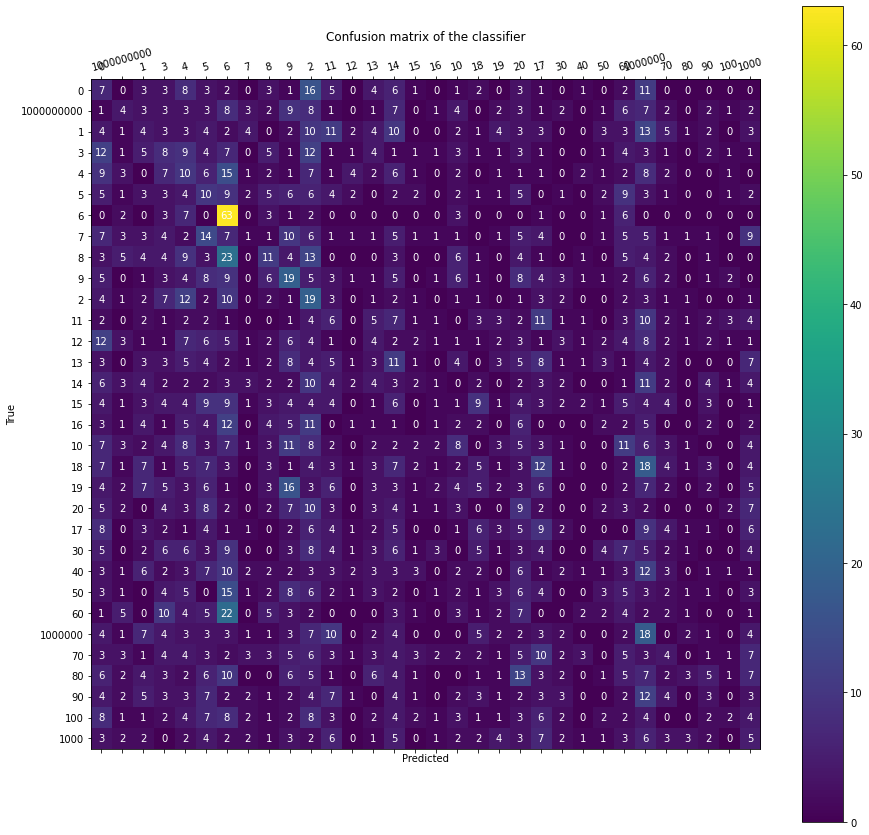

In [30]:
confusion_matrix_heatmap(y_val, yv_p)

## CNN approach

In [ ]:
pip install plot_keras_history

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from plot_keras_history import plot_history

In [4]:
spectrograms = np.load('/content/drive/MyDrive/Data/MLEnd/spectrograms.npy')

In [16]:
print(y_dig)

[ 18  90   1 ...  12 100  15]


In [23]:
from sklearn.preprocessing import LabelEncoder

y_isDig = True
if y_isDig:
    le = LabelEncoder()
    y_dig_enc = le.fit_transform(y_dig)
    print('yshape is:', y_dig_enc.shape)
 
print(y_dig[:10])

yshape is: (20000,)
[     18      90       1      15      15      70 1000000     100      80
       6]


In [21]:
 from sklearn.model_selection import train_test_split

train_spectrograms, test_spectrograms, y_train2, y_test2 = train_test_split(spectrograms, y_dig_enc, test_size=0.15)

# split train into train-dev
y_train2 = to_categorical(y_train2, num_classes=32)
y_test2 = to_categorical(y_test2, num_classes=32)
y_train2.shape

(17000, 32)

In [28]:
train_spectrograms[0].shape

(1025, 40)

In [29]:
train_X_ex = np.expand_dims(train_spectrograms, -1)
test_X_ex = np.expand_dims(test_spectrograms, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (17000, 1025, 40, 1)
test X shape: (3000, 1025, 40, 1)


In [36]:
import keras
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten
from keras import Input, Model

ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(128, activation='relu')(m)
op = Dense(32, activation='softmax')(m)

model = Model(inputs=ip, outputs=op)

checkpoint_filepath = '/content/drive/MyDrive/Data/MLEnd/tmp/checkpoint'

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
   checkpoint_filepath, monitor="val_loss", save_best_only=True
)


model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1025, 40, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1022, 37, 64)      1088      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 255, 9, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 255, 9, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 146880)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               18800768  
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          y_train2,
          epochs=10,  # maybe reduce the number of epochs? Using early stopping nullifies this.
          batch_size=32,  # change the batch size?
          verbose=1,
          validation_data=(test_X_ex, y_test2)  # should use validation data rather than test data...
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])  # didn't add this to initial run, would likely have stopped at around the 5th epoch otherwise
          # saves the weights of the model before overfitting to improve deployment performance.

Epoch 1/10
532/532 [==============================] - 280s 523ms/step - loss: 3.4773 - accuracy: 0.1385 - val_loss: 2.4770 - val_accuracy: 0.2913
Epoch 2/10
532/532 [==============================] - 290s 544ms/step - loss: 2.0989 - accuracy: 0.3816 - val_loss: 2.1895 - val_accuracy: 0.3607
Epoch 3/10
532/532 [==============================] - 283s 532ms/step - loss: 1.5815 - accuracy: 0.5261 - val_loss: 2.1456 - val_accuracy: 0.4070
Epoch 4/10
532/532 [==============================] - 279s 525ms/step - loss: 1.2435 - accuracy: 0.6202 - val_loss: 2.2003 - val_accuracy: 0.4207
Epoch 5/10
532/532 [==============================] - 283s 532ms/step - loss: 0.9726 - accuracy: 0.7013 - val_loss: 2.3510 - val_accuracy: 0.4317
Epoch 6/10
532/532 [==============================] - 285s 536ms/step - loss: 0.8360 - accuracy: 0.7436 - val_loss: 2.5700 - val_accuracy: 0.4220
Epoch 7/10
532/532 [==============================] - 283s 532ms/step - loss: 0.6990 - accuracy: 0.7886 - val_loss: 2.7244 -

Looking at the validation loss the model reached peak performance around the third epoch in terms of losss though its val accuracy continues to increase by around 2%

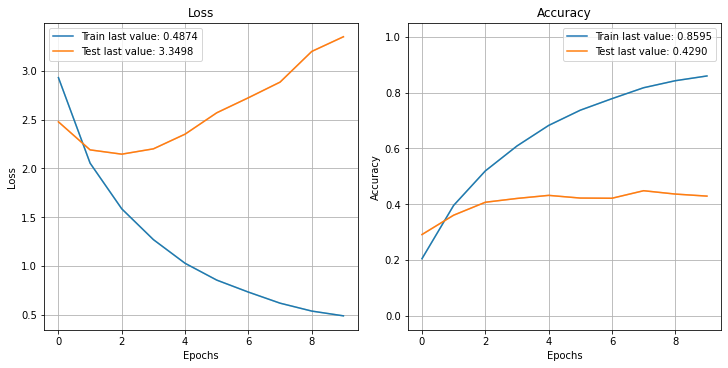

In [38]:
plot_history(history.history, path="standard.png")
plt.show()

As mentioned above from reading the text progress one can see the validation loss increasing after the second epoch and the validation accuracy plateauing at around the second, with only a small increase after that.